# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Note
All used cars dealerships are interested in profits, but since we do not have the data related to the price the dealer bought the car for, we have to look at other factors which can be important for the dealership. The purpose of this task is to advise a dealership on what car features influence the price and to build a price prediction tool that can be used by the dealership to make decisions on the inventory. 

#### Make this a data task

1. Can we use the available data to build a prediction tool for the price of card sold to be used by the dealership in making decisions?

2. What data can be ignored in the analysis?

3. In the dataset, how do we best handle the missing data, do we drop or fill in missing data?

4. What are the top features that influence the price of a car sold?

5. What is missing, how can we improve the dataset and the analysis as the next steps?

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
# Import the necessary libraries from pandas, sklearn, and visualization libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config(display="diagram")

In [2]:
#Import the data
df = pd.read_csv('data/vehicles.csv')

In [3]:
#First look at the dataset
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Start looking at the data.  

From start, it is clear that VIN is unneccssary, it is just info - it is very rarley that a buyer would look at the VIN to see the mfg origin, plus half of the VIN data is missing, so this column will be dropped. Same with id which does not give any useful info since the numbers are randomly generated.

In [4]:
df = df.drop(columns = ['id', 'VIN'])

Cylinders can be easily converted to numbers, so let's do so

In [5]:
#replace the cylinders with floats, replace 'other' with 4
df['cylinders'] = df['cylinders'].str.replace('other','4')
df['cylinders'] = df['cylinders'].str.replace(' cylinders','')
df['cylinders'] = df['cylinders'].astype(float)

The data gives the mfg year, so we can convert this data to age of the car, column which we will call 'old'

In [6]:
df['old'] = 2022 - df['year']
df = df.drop(['year'], axis=1)

Let see the categories and how they relate

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  float64
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  state         426880 non-null  object 
 15  old           425675 non-null  float64
dtypes: float64(3), int64(1), object(12)
memory usage: 52.1+ MB


We ignore for now the missing values

We also want to look at the models, typically the dealerships record detailed description under the model such that the data might not be relevant if the number of variants is too high.

In [8]:
#see how many unique model values we have
len(df['model'].unique())

29650

In [9]:
# there are 3875 models entered as unique values only for Ford vehicles, which is far from any reasonable reality
len(df.loc[df['manufacturer'] == 'ford']['model'].unique())

3875

We might decide to drop this columns, will see during modeling

How the region influences the price of a car? From experience, the same car sells for more money in different counties, for example in California.

In [10]:
#take the data for California and look at cars made my Ford as an example
df_ca_ford = df.loc[(df['state'] == 'ca') & (df['manufacturer'] == 'ford')&(df['price']<60000)]

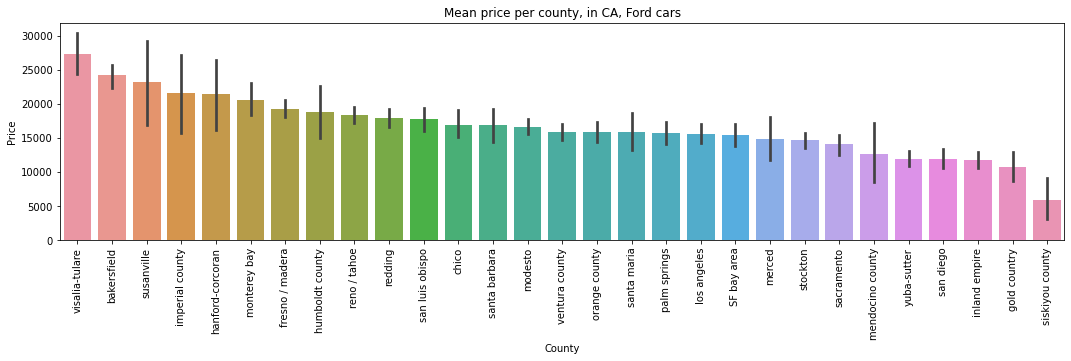

In [11]:
#visualize Ford in California, mean price per region
plt.figure(figsize=(18, 4))
sns.barplot(data = df_ca_ford, x = 'region', y = 'price',
           order = df_ca_ford.groupby(['region'])['price'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('County')
plt.ylabel('Price')
plt.title('Mean price per county, in CA, Ford cars');

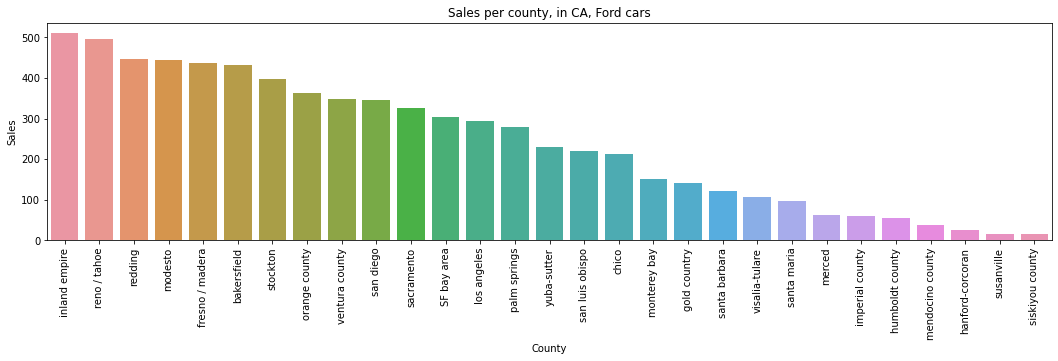

In [12]:
#check the sales distribution across counties in CA - all counties sell 
plt.figure(figsize=(18, 4))
sns.countplot(df_ca_ford['region'], order = df_ca_ford['region'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('County')
plt.ylabel('Sales')
plt.title('Sales per county, in CA, Ford cars');

In [13]:
# There are 404 different regions/counties
len(df['region'].unique())

404

The number of distinct regions is high, it might be difficult to encode, but can be useful to keep since the price is depending on the county in each state. We can encode either binary or OneHot

Look at the sales and price per state to understand how these vary across the US

In [14]:
#limit the price at $150k for these visualizations, we do not look at the outliers yet; ignore below $250
df = df.drop(df.loc[df['price'] > 150000].index)
df = df.drop(df.loc[df['price'] < 250].index)

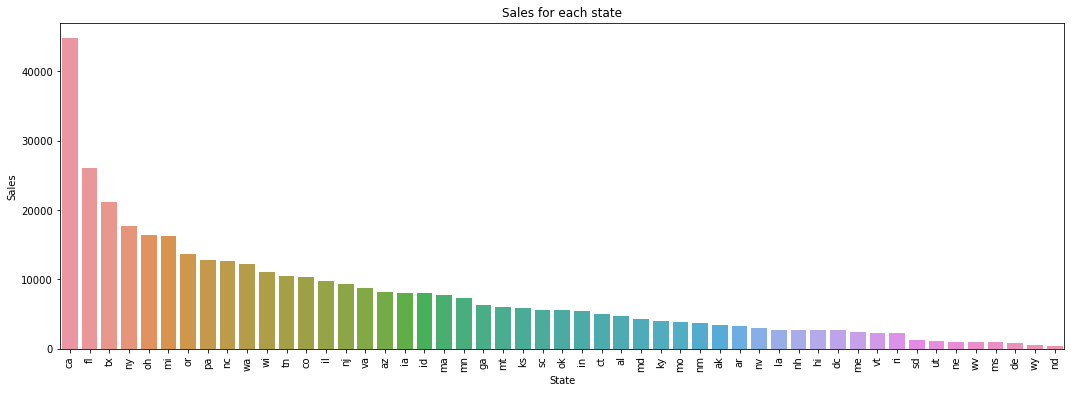

In [15]:
#explore the sales per state
plt.figure(figsize=(18, 6))
sns.countplot(df['state'],order = df['state'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('State')
plt.ylabel('Sales')
plt.title('Sales for each state');

Note: CA, FL, TX and NY are the states with the highest sales

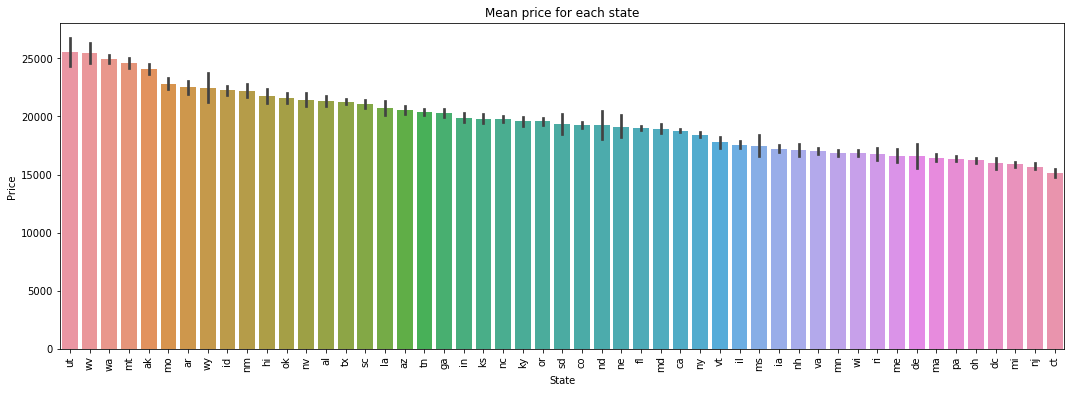

In [16]:
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'state', y = 'price',
           order = df.groupby(['state'])['price'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('State')
plt.ylabel('Price')
plt.title('Mean price for each state');

Looking at some other features

In [17]:
len(df['manufacturer'].unique())

43

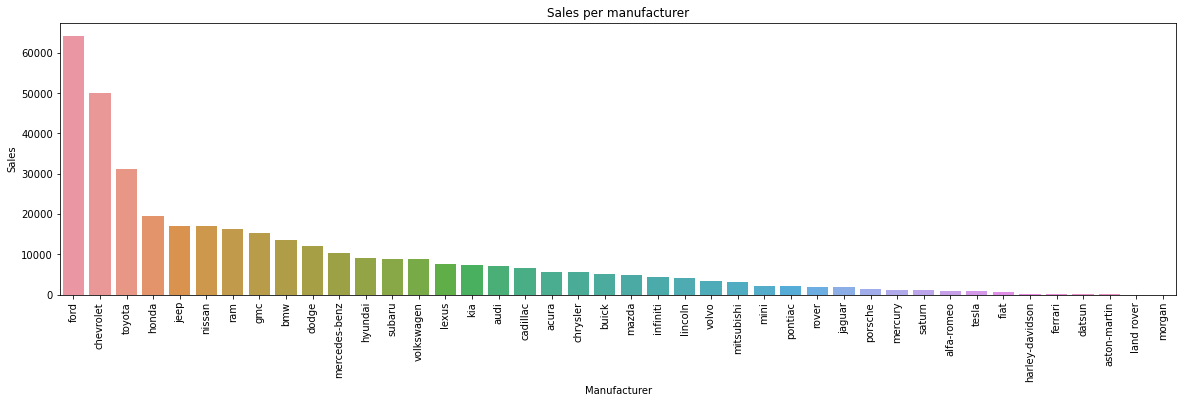

In [18]:
#explore the manufacturers
plt.figure(figsize=(20, 5))
sns.countplot(df['manufacturer'],order = df['manufacturer'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Manufacturer')
plt.ylabel('Sales')
plt.title('Sales per manufacturer');

Best sellers are Ford, Chevrolet, Toyota followed by Nissan, Jeep, Honda, BMW, Ram, GMC, Dodge

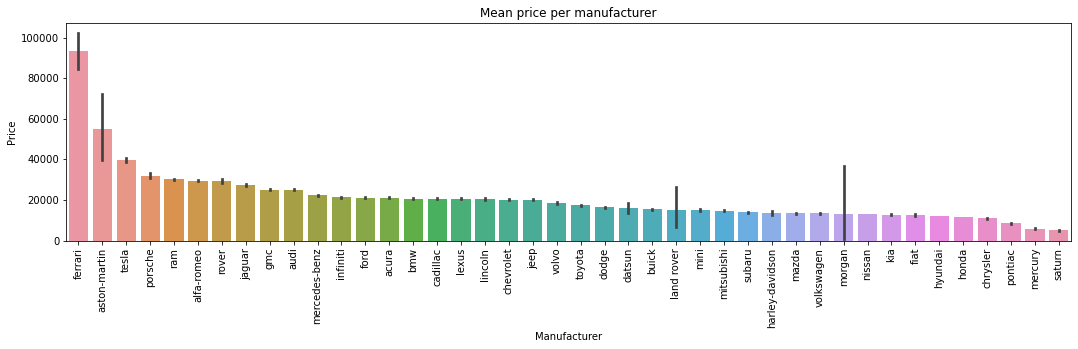

In [19]:
#also interesting a visualization of price per mfg
plt.figure(figsize=(18, 4))
sns.barplot(data = df, x = 'manufacturer', y = 'price',
           order = df.groupby(['manufacturer'])['price'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.title('Mean price per manufacturer');

Noticing high price for Ferrari and Aston Martin, which are quite rare, not the typical used cars, so we might drop these two manufacturers. Also Land Rover and Morgan have large error bars, so we might drop these as well

In [20]:
#looking into how many entries are for these four manufacturers
len(df.loc[df['manufacturer'].isin(['aston-martin','ferrari', 'land rover','morgan'])])

96

Looking at the vehicle type

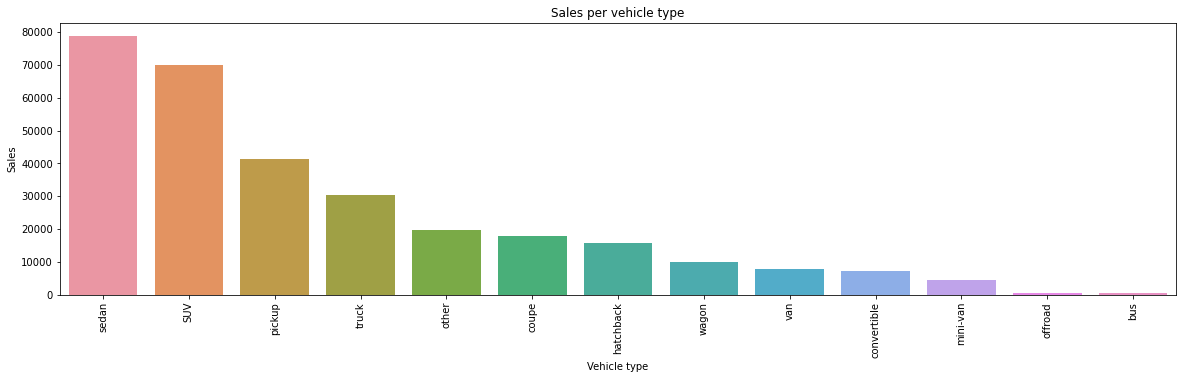

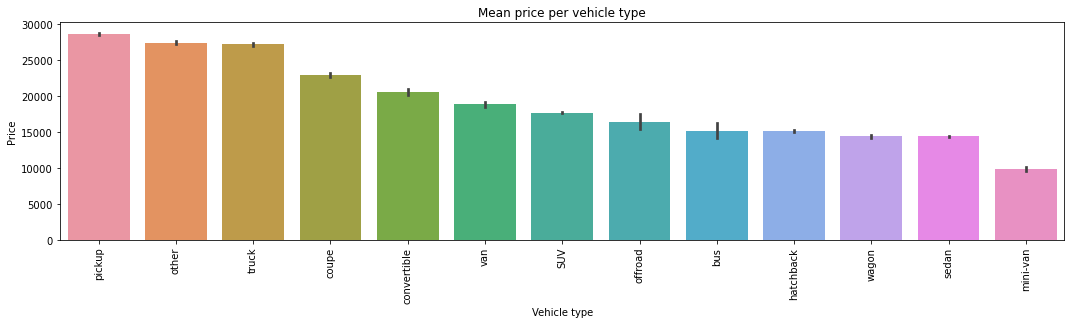

In [21]:
plt.figure(figsize=(20, 5))
sns.countplot(df['type'],order = df['type'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Vehicle type')
plt.ylabel('Sales')
plt.title('Sales per vehicle type');
#
plt.figure(figsize=(18, 4))
sns.barplot(data = df, x = 'type', y = 'price', 
            order = df.groupby(['type'])['price'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Vehicle type')
plt.ylabel('Price')
plt.title('Mean price per vehicle type');

We can continue with the visualizations, but these I consider important

Let's look at the title status.

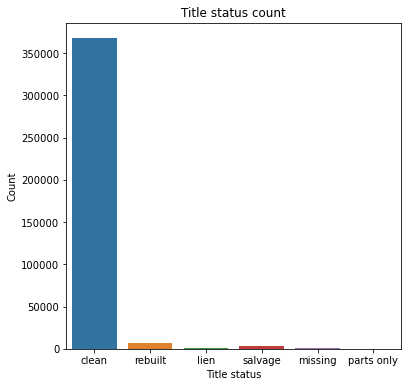

In [22]:
#check the title status; I will be intersted only in clean titles, as this would be a sound business decision
plt.figure(figsize=(6, 6))
#df['title_status'].value_counts()
sns.countplot(df['title_status']);
plt.xlabel('Title status')
plt.ylabel('Count')
plt.title('Title status count');

I will keep only the data for the clean titles. For the unclean titles, the price is in general the result of unique negotiation on the spot and should be avoided by the dealers. 

There are a lot of missing values, so we need to decide what to do with them. 

In [23]:
#Look at the dataset categories with missing data
df.isnull().sum()

region               0
price                0
manufacturer     15724
model             4548
condition       148064
cylinders       158032
fuel              2594
odometer          2226
title_status      7483
transmission      1816
drive           118301
size            279631
type             83877
paint_color     114105
state                0
old               1173
dtype: int64

Take a look at the data per category, to see if we can replace the NaN with some values.  

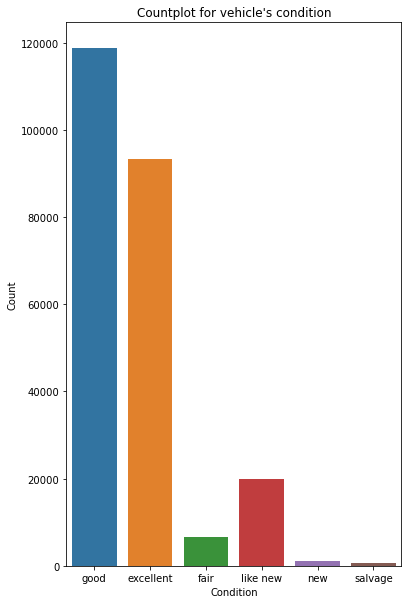

In [24]:
#explore the cvehicle condition
plt.figure(figsize=(6, 10))
sns.countplot(df['condition']);
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Countplot for vehicle\'s condition');

We can replace the missing values with 'good'

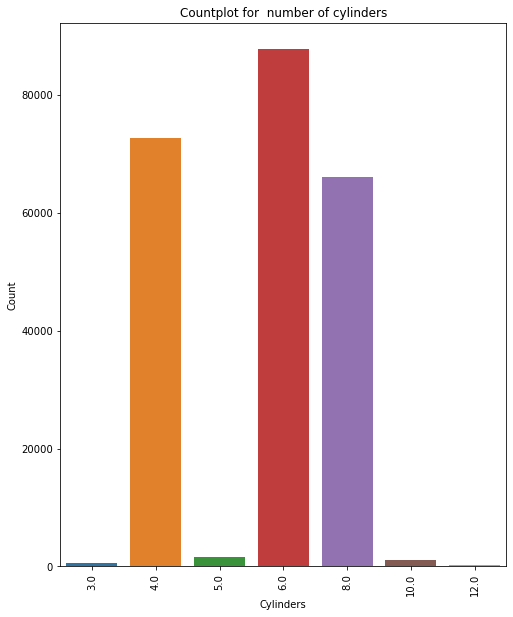

In [25]:
#explore the number of cylinders
plt.figure(figsize=(8, 10))
sns.countplot(df['cylinders'])
plt.xticks(rotation = 90);
plt.xlabel('Cylinders')
plt.ylabel('Count')
plt.title('Countplot for  number of cylinders');

We can replace missing values with, for example, 6 cylinders for all the SUV, offroad, truck and pickup and with 4 for the rest. 

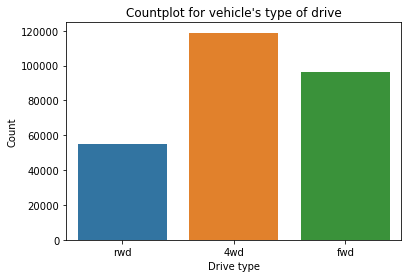

In [26]:
#explore the types of drive
sns.countplot(df['drive'])
plt.xlabel('Drive type')
plt.ylabel('Count')
plt.title('Countplot for vehicle\'s type of drive');

From the drive type, we can replace missing values with 4wd for all the SUV, offroad, truck and pickup, and with fwd for the rest. We can even go more in detail, for example all the Mercedes and BMW sedans are rwd. 

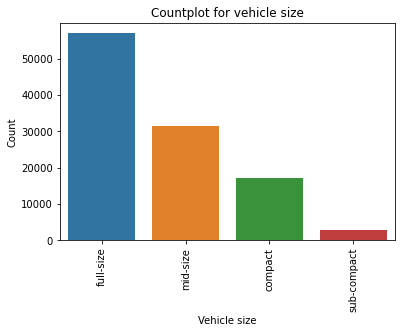

In [27]:
#explore the vehicle sizes
sns.countplot(df['size'])
plt.xticks(rotation = 90);
plt.xlabel('Vehicle size')
plt.ylabel('Count')
plt.title('Countplot for vehicle size');

We can replace the missing values with appropriate values, based on known categorization of vehicles, for example we can use 'full-size' for SUV, trucks, etc. 

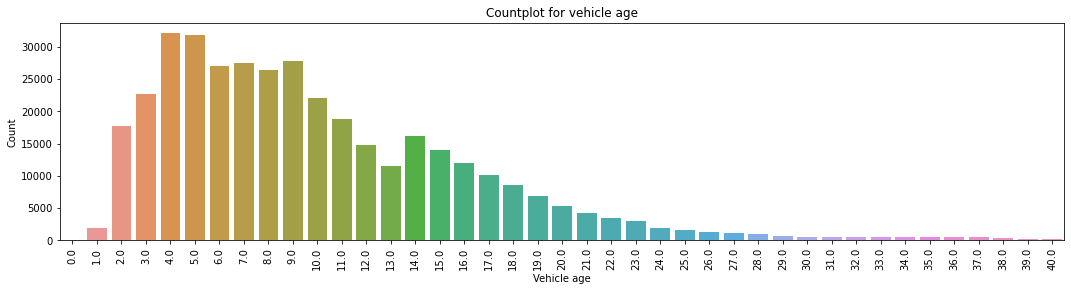

In [28]:
#limit the age of the vehicle to 40 years for better visualization
df = df.drop(df.loc[df['old'] > 40].index)
plt.figure(figsize=(18, 4))
sns.countplot(df['old'])
plt.xlabel('Vehicle age')
plt.ylabel('Count')
plt.xticks(rotation = 90);
plt.title('Countplot for vehicle age');

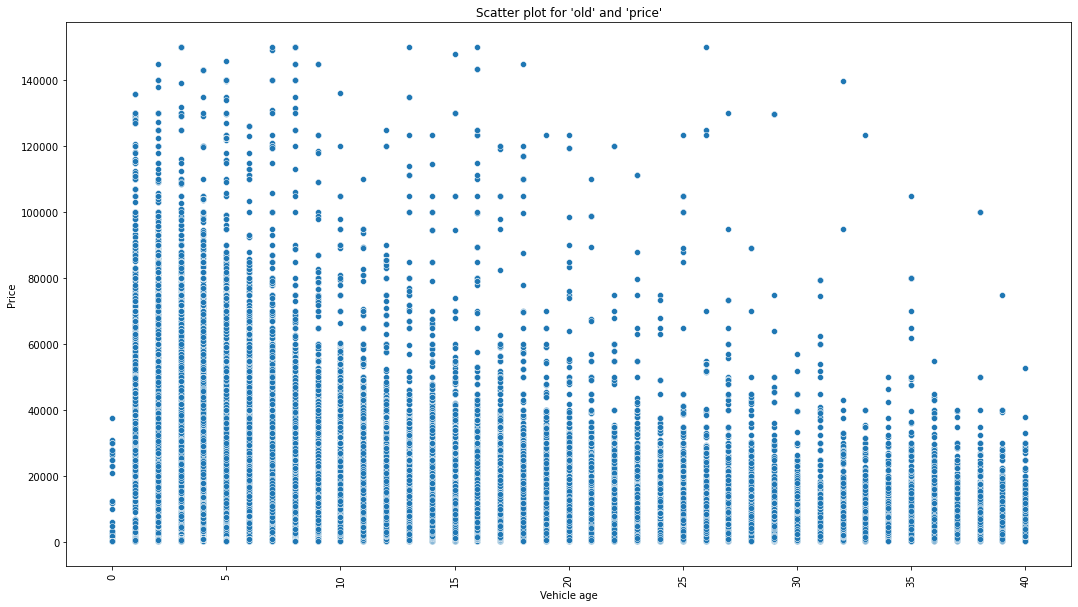

In [29]:
#scatter of price and age, reasonable distribution
plt.figure(figsize=(18, 10))
sns.scatterplot(data = df, x = 'old', y = 'price')
plt.xlabel('Vehicle age')
plt.ylabel('Price')
plt.xticks(rotation = 90);
plt.title('Scatter plot for \'old\' and \'price\'');

Let's see the correlation matrix

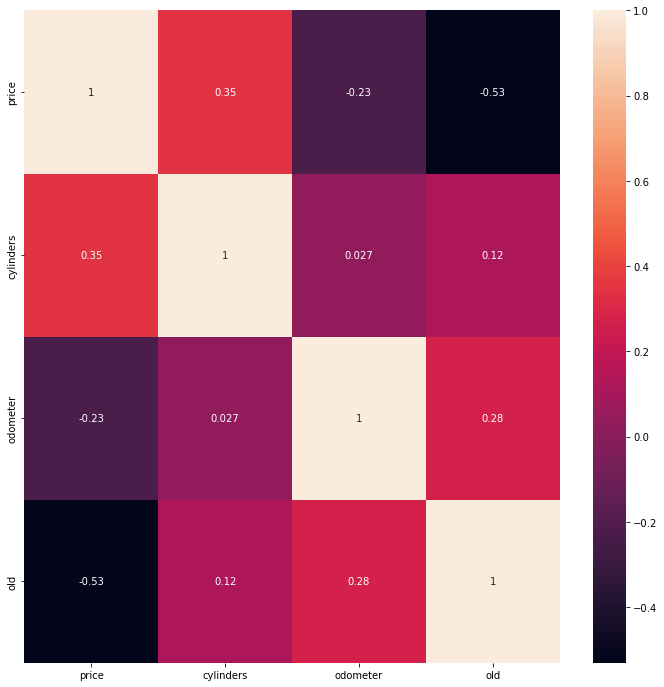

In [30]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df.corr(), annot=True);

The correlation matrix shows expected correlations - the price goes down as the age of the car increases along with the odometer, which is expected.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Now we proceed to data cleaning and replacing the missing values

First step is to look at the outliers which can be very problematic for modeling

In [31]:
#reload the data
df = pd.read_csv('data/vehicles.csv')

In [32]:
#as above, prepare the dataset removing VIN, id, changing cylinders to floats, 
#changing the make year to vehicle age
df = df.drop(columns = ['id', 'VIN'])
df['cylinders'] = df['cylinders'].str.replace('other','4')
df['cylinders'] = df['cylinders'].str.replace(' cylinders','')
df['cylinders'] = df['cylinders'].astype(float)
df['age'] = 2022 - df['year']
df = df.drop(['year'], axis=1)
#keeping only the clean titles
df = df.loc[df['title_status'] == 'clean']
#since we only consider the clean titles, we can now drop the column, it will not influence the modeling
df = df.drop(columns = 'title_status')

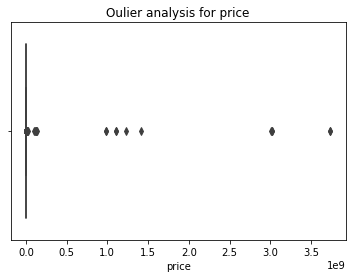

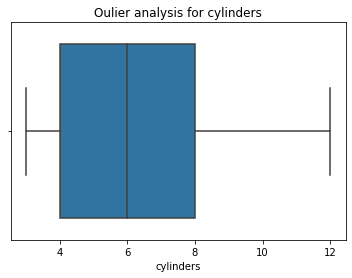

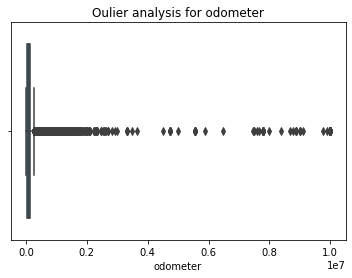

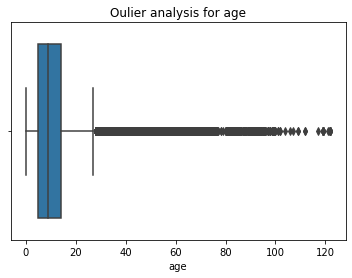

In [33]:
#visualize the outliers for the numeric values, columns 'price', 'year', 'cylinders' and 'odometer'.
col_outl = df.select_dtypes(include=['int64','float64']).columns.tolist()
for i in col_outl:
    plt.figure()
    sns.boxplot(x=df[i])
    plt.title('Oulier analysis for '+i)

In [34]:
# clean up the outliers
#remove prices above $57k and below $250
df = df.drop(df.loc[df['price'] > 57000].index)
df = df.drop(df.loc[df['price'] < 250].index)

In [35]:
#removing cars older than 22 years
#see how many entries are above 22 years first
len(df.loc[df['age']>22])

22668

In [36]:
df = df.drop(df.loc[df['age'] > 22].index)

In [37]:
#odometer above 200k miles
len(df.loc[df['odometer']>200000])

17603

In [38]:
df = df.drop(df.loc[df['odometer'] > 200000].index)
df = df.drop(df.loc[df['odometer'] < 100].index)

In [39]:
df = df.drop(df.loc[df['cylinders'] > 8].index)

In [40]:
#dropping the rare vehicles
df = df.drop(df.loc[df['manufacturer'].isin(['aston-martin','ferrari', 'land rover','morgan'])].index)

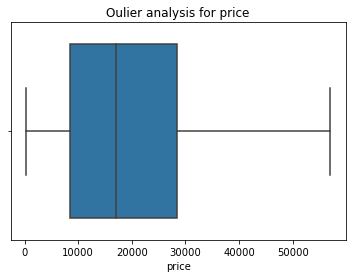

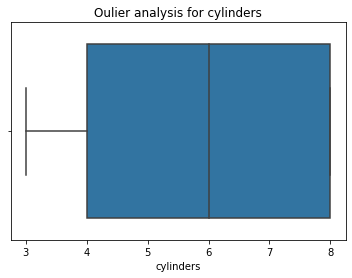

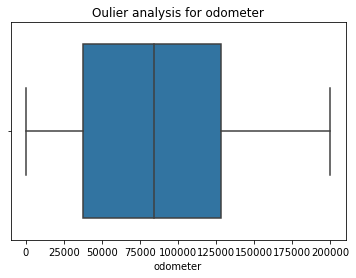

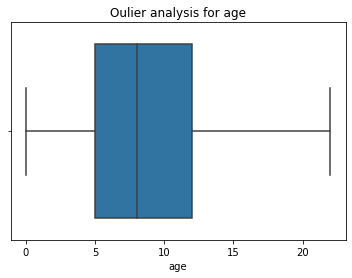

In [41]:
#look again for outliers
col_outl = df.select_dtypes(include=['int64','float64']).columns.tolist()
for i in col_outl:
    plt.figure()
    sns.boxplot(x=df[i])
    plt.title('Oulier analysis for '+i)

In [42]:
# look at the null values
df.isnull().sum()

region               0
price                0
manufacturer      9131
model             2225
condition       122576
cylinders       135160
fuel              1518
odometer          1823
transmission      1271
drive            95024
size            232065
type             61886
paint_color      87047
state                0
age                501
dtype: int64

Start replacing missing values as suggested in the first part

In [43]:
#replacing NaN with 'good' in 'condition'
df.loc[df['condition'].isnull(), 'condition'] = 'good'

In [44]:
#we are going to use 'type' as reference to replace missing values
#first replace some of the 'type' missing values, using 'drive'
df.loc[(df['type'].isnull())&(df['drive'] == '4wd')&(df['cylinders'].isin([8,10])), 'type'] = 'truck'
df.loc[(df['type'].isnull())&(df['drive'] == '4wd')&(df['cylinders'].isin([4,6])), 'type'] = 'SUV'
df.loc[(df['type'].isnull())&(df['drive'] == 'fwd')&(df['cylinders'].isin([4,6])), 'type'] = 'sedan'

In [45]:
#replace cylinders missing values
df.loc[(df['cylinders'].isnull())&(df['type'].isin(['SUV','offroad','truck','pickup','bus'])), 'cylinders'] = 6
df.loc[(df['cylinders'].isnull())&(df['type'].isin(['other','coupe','hatchback','mini-van',
                                                    'sedan','convertible','wagon','van'])), 'cylinders'] = 4

In [46]:
#replace drive missing values
df.loc[(df['drive'].isnull())&(df['type'].isin(['SUV','offroad','truck','pickup'])), 'drive'] = '4wd'
df.loc[(df['drive'].isnull())&(df['type'] =='bus'), 'drive'] = 'rwd'
df.loc[(df['drive'].isnull())&(df['type'] =='sedan')&(df['manufacturer'].isin(['mercedes-benz','bmw'])),
                                                                                   'drive'] = 'rwd'
df.loc[(df['drive'].isnull())&(df['type'].isin(['other','coupe','hatchback','mini-van',
                                                    'sedan','convertible','wagon','van'])), 'drive'] = 'fwd'

In [47]:
#replace size missing values
df.loc[(df['size'].isnull())&(df['type'].isin(['SUV','offroad','truck','pickup',
                                               'bus','wagon','van'])), 'size'] = 'full-size'
df.loc[(df['size'].isnull())&(df['type'].isin(['coupe','convertible'])), 'size'] = 'compact'
df.loc[(df['size'].isnull())&(df['type'].isin(['other','hatchback','mini-van','sedan'])), 'size'] = 'compact'

In [48]:
#check the missing values again
df.isnull().sum()

region              0
price               0
manufacturer     9131
model            2225
condition           0
cylinders       43976
fuel             1518
odometer         1823
transmission     1271
drive           40016
size            50221
type            51313
paint_color     87047
state               0
age               501
dtype: int64

In [49]:
#we can now drop the rest of the missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206029 entries, 27 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        206029 non-null  object 
 1   price         206029 non-null  int64  
 2   manufacturer  206029 non-null  object 
 3   model         206029 non-null  object 
 4   condition     206029 non-null  object 
 5   cylinders     206029 non-null  float64
 6   fuel          206029 non-null  object 
 7   odometer      206029 non-null  float64
 8   transmission  206029 non-null  object 
 9   drive         206029 non-null  object 
 10  size          206029 non-null  object 
 11  type          206029 non-null  object 
 12  paint_color   206029 non-null  object 
 13  state         206029 non-null  object 
 14  age           206029 non-null  float64
dtypes: float64(3), int64(1), object(11)
memory usage: 25.2+ MB


The dataset is now clean and has 206029 rows, plenty of data to work with.

Now we have to decide what type of encoding we will use.

Columns 'cylinders', 'odometer' and 'age' will go through a Standard Scaler since they are numeric.

In [50]:
#region has a large number of unique values, Binary encode might work. If it affects the modeling we will
#drop the column or use OneHot
len(df['region'].unique())

403

In [51]:
#manufacturer will use OneHotEncoder
len(df['manufacturer'].unique())

37

In [52]:
#condition will use OneHotEncoder
len(df['condition'].unique())

6

In [53]:
# binary encoder for 'model' or drop the column entirely
len(df['model'].unique())

12825

In [54]:
#fuel will use OneHotEncoder
len(df['fuel'].unique())

5

In [55]:
#transmission will use OneHotEncoder
len(df['transmission'].unique())

3

In [56]:
#drive will use OneHotEncoder
len(df['drive'].unique())

3

In [57]:
#size will use OneHotEncoder
len(df['size'].unique())

4

In [58]:
#type will use OneHotEncoder
len(df['type'].unique())

13

In [59]:
#paint_color will use OneHotEncoder
len(df['paint_color'].unique())

12

In [60]:
#state will use binary encoding
len(df['state'].unique())

51

In [61]:
#resetting the index
df = df.reset_index(drop = True)

In [62]:
#look at the data
df.head()

,region,price,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state,age
0,auburn,33590,gmc,sierra 1500 crew cab slt,good,8.0,gas,57923.0,other,4wd,full-size,pickup,white,al,8.0
1,auburn,22590,chevrolet,silverado 1500,good,8.0,gas,71229.0,other,4wd,full-size,pickup,blue,al,12.0
2,auburn,39590,chevrolet,silverado 1500 crew,good,8.0,gas,19160.0,other,4wd,full-size,pickup,red,al,2.0
3,auburn,30990,toyota,tundra double cab sr,good,8.0,gas,41124.0,other,4wd,full-size,pickup,red,al,5.0
4,auburn,15000,ford,f-150 xlt,excellent,6.0,gas,128000.0,automatic,rwd,full-size,truck,black,al,9.0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [63]:
#setting up the train and test sets
X = df.drop(columns = ['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [64]:
#checking the train set
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154521 entries, 2417 to 109429
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        154521 non-null  object 
 1   manufacturer  154521 non-null  object 
 2   model         154521 non-null  object 
 3   condition     154521 non-null  object 
 4   cylinders     154521 non-null  float64
 5   fuel          154521 non-null  object 
 6   odometer      154521 non-null  float64
 7   transmission  154521 non-null  object 
 8   drive         154521 non-null  object 
 9   size          154521 non-null  object 
 10  type          154521 non-null  object 
 11  paint_color   154521 non-null  object 
 12  state         154521 non-null  object 
 13  age           154521 non-null  float64
dtypes: float64(3), object(11)
memory usage: 17.7+ MB


As a reference we can calculate baseline MAE for train and test sets using the mean y values (MAE is less sensitive to outliers)

In [65]:
train_base = np.ones(shape = y_train.shape)*y_train.mean()
test_base = np.ones(shape = y_test.shape)*y_test.mean()
mae_train_base = median_absolute_error(train_base, y_train)
mae_test_base = median_absolute_error(test_base, y_test)
print(f'Train baseline MAE: {mae_train_base}')
print(f'Test baseline MAE: {mae_test_base}')

Train baseline MAE: 10019.059855941912
Test baseline MAE: 10058.318416556653


Create a column transformer using the defined classes of objects

In [66]:
#column sets
col_hot = ['manufacturer','condition','fuel','transmission','drive','size','type','paint_color', 'state']
col_bin = ['region', 'model']
col_std = ['cylinders','odometer','age']

In [67]:
#create the col transformer
transformer = make_column_transformer(
                (OneHotEncoder(drop="if_binary"), col_hot),
                (ce.BinaryEncoder(),col_bin),
                (StandardScaler(), col_std), remainder ='passthrough')

We now create pipelines, extract MAE and Score and features importance.

The metrics we look for are the score which we want maximized and the MAE which we want to minimize, or the best combination of both. 

In [68]:
#create first pipeline just with LinearRegression
pipe1 = Pipeline([('transformer', transformer),
                    ('model', LinearRegression())])
pipe1.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['region', 'model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'odometer',
                                                   'age'])])),
                ('model', LinearRegression())])

In [69]:
pred1_train = pipe1.predict(X_train)
pred1_test = pipe1.predict(X_test)
score1 = pipe1.score(X_test, y_test)
print(f'Pipe1 Train MAE: {median_absolute_error(y_train, pred1_train)}')
print(f'Pipe1 Test MAE: {median_absolute_error(y_test, pred1_test)}')
print(f'Pipe1 Accuracy Score: {score1}')
values = []
values.append(['Linear', median_absolute_error(y_train, pred1_train),median_absolute_error(y_test, pred1_test),
             score1])

Pipe1 Train MAE: 3370.506205204949
Pipe1 Test MAE: 3386.2530237594083
Pipe1 Accuracy Score: 0.7591465749989657


In [70]:
#pipe 2 with Ridge default
pipe2 = Pipeline([('transformer', transformer),
                    ('model', Ridge(random_state = 22))])
pipe2.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['region', 'model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'odometer',
                                                   'age'])])),
                ('model', Ridge(random_state=22))])

In [71]:
pred2_train = pipe2.predict(X_train)
pred2_test = pipe2.predict(X_test)
score2 = pipe2.score(X_test, y_test)
print(f'Pipe2 Train MAE: {median_absolute_error(y_train, pred2_train)}')
print(f'Pipe2 Test MAE: {median_absolute_error(y_test, pred2_test)}')
print(f'Pipe2 Accuracy Score: {score2}')
values.append(['Ridge', median_absolute_error(y_train, pred2_train),median_absolute_error(y_test, pred2_test),
             score2])

Pipe2 Train MAE: 3371.5379777501294
Pipe2 Test MAE: 3387.8321341313804
Pipe2 Accuracy Score: 0.7591485648213712


In [72]:
#pipe 3 with Lasso default
pipe3 = Pipeline([('transformer', transformer),
                    ('model', Lasso(random_state = 22))])
pipe3.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['region', 'model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'odometer',
                                                   'age'])])),
                ('model', Lasso(random_state=22))])

In [73]:
pred3_train = pipe3.predict(X_train)
pred3_test = pipe3.predict(X_test)
score3 = pipe3.score(X_test, y_test)
print(f'Pipe3 Train MAE: {median_absolute_error(y_train, pred3_train)}')
print(f'Pipe3 Test MAE: {median_absolute_error(y_test, pred3_test)}')
print(f'Pipe3 Accuracy Score: {score3}')
values.append(['Lasso', median_absolute_error(y_train, pred3_train),median_absolute_error(y_test, pred3_test),
             score3])

Pipe3 Train MAE: 3371.757663287348
Pipe3 Test MAE: 3384.5737951553983
Pipe3 Accuracy Score: 0.7591032879951846


In [74]:
#pipe 4 with TransformedTargetRegressor with Ridge regressor
pipe4 = Pipeline([('transformer', transformer),
                    ('model', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))])
pipe4.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['region', 'model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'odometer',
                                                   'age'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge()))])

In [75]:
pred4_train = pipe4.predict(X_train)
pred4_test = pipe4.predict(X_test)
score4 = pipe4.score(X_test, y_test)
print(f'Pipe4 Train MAE: {median_absolute_error(y_train, pred4_train)}')
print(f'Pipe4 Test MAE: {median_absolute_error(y_test, pred4_test)}')
print(f'Pipe4 Accuracy Score: {score4}')
values.append(['TTR_Ridge', median_absolute_error(y_train, pred4_train),median_absolute_error(y_test, pred4_test),
             score4])

Pipe4 Train MAE: 2763.155207365806
Pipe4 Test MAE: 2765.9163525966997
Pipe4 Accuracy Score: 0.7206183176638035


In [76]:
#pipe 5 with TransformedTargetRegressor with RFR as regressor
pipe5 = Pipeline([('transformer', transformer),
            ('model', TransformedTargetRegressor(regressor = RandomForestRegressor(n_estimators = 5, 
                                        random_state = 22), func=np.log, inverse_func=np.exp))])
pipe5.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['region', 'model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'odometer',
                                                   'age'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=5,
                                                                            random_state=22)))])

In [77]:
pred5_train = pipe5.predict(X_train)
pred5_test = pipe5.predict(X_test)
score5 = pipe5.score(X_test, y_test)
print(f'Pipe5 Train MAE: {median_absolute_error(y_train, pred5_train)}')
print(f'Pipe5 Test MAE: {median_absolute_error(y_test, pred5_test)}')
print(f'Pipe5 Accuracy Score: {score5}')
values.append(['TTR_RFR', median_absolute_error(y_train, pred5_train),median_absolute_error(y_test, pred5_test),
             score5])

Pipe5 Train MAE: 137.50371366407398
Pipe5 Test MAE: 740.3549222690035
Pipe5 Accuracy Score: 0.8917395873529315


In [78]:
#pipe 6 with TransformedTargetRegressor and Lasso as regressor
pipe6 = Pipeline([('transformer', transformer),
            ('model', TransformedTargetRegressor(regressor = Lasso(random_state = 22)))])
pipe6.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['region', 'model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'odometer',
                                                   'age'])])),
                ('model',
                 TransformedTargetRegressor(regressor=Lasso(random_state=22)))])

In [79]:
pred6_train = pipe6.predict(X_train)
pred6_test = pipe6.predict(X_test)
score6 = pipe6.score(X_test, y_test)
print(f'Pipe6 Train MAE: {median_absolute_error(y_train, pred6_train)}')
print(f'Pipe6 Test MAE: {median_absolute_error(y_test, pred6_test)}')
print(f'Pipe6 Accuracy Score: {score6}')
values.append(['TTR_Lasso', median_absolute_error(y_train, pred6_train),median_absolute_error(y_test, pred6_test),
             score6])

Pipe6 Train MAE: 3371.757663287348
Pipe6 Test MAE: 3384.5737951553983
Pipe6 Accuracy Score: 0.7591032879951846


Cross Validation

In [80]:
#GridSearchCV parameters
param1 = {'model__regressor__alpha': np.logspace(0, 10, 10)}
param2 = {'model__alpha': np.logspace(0, 10, 10)}

In [81]:
#grid for pipe2
grid2 = GridSearchCV(pipe2, param2)
grid2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['manufacturer',
                                                                          'condition',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['region',
                                                                          'model']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['cylinders',
                                                                          'odometer',
                                                                          'age'])])),
                                       ('model', Ridge(random_state=22))]),
             param_grid={'model__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10])})

In [82]:
pred_train_grid2 = grid2.predict(X_train)
pred_test_grid2 = grid2.predict(X_test)
grid2_train_mae = median_absolute_error(y_train, pred_train_grid2)
grid2_test_mae = median_absolute_error(y_test, pred_test_grid2)
print(f'Grid2 Train MAE: {round(grid2_train_mae, 2)}')
print(f'Grid2 Test MAE: {round(grid2_test_mae, 2)}')
print(f'Best parameter: {grid2.best_params_}')
print(f'Best score: {grid2.best_score_}')
values.append(['Grid_Ridge', grid2_train_mae, grid2_test_mae,grid2.best_score_])

Grid2 Train MAE: 3371.54
Grid2 Test MAE: 3387.83
Best parameter: {'model__alpha': 1.0}
Best score: 0.7562424568641325


In [83]:
#grid for pipe3
grid3 = GridSearchCV(pipe3, param2)
grid3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['manufacturer',
                                                                          'condition',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['region',
                                                                          'model']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['cylinders',
                                                                          'odometer',
                                                                          'age'])])),
                                       ('model', Lasso(random_state=22))]),
             param_grid={'model__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10])})

In [84]:
pred_train_grid3 = grid3.predict(X_train)
pred_test_grid3 = grid3.predict(X_test)
grid3_train_mae = median_absolute_error(y_train, pred_train_grid3)
grid3_test_mae = median_absolute_error(y_test, pred_test_grid3)
print(f'Grid3 Train MAE: {round(grid3_train_mae, 2)}')
print(f'Grid3 Test MAE: {round(grid3_test_mae, 2)}')
print(f'Best parameter: {grid3.best_params_}')
print(f'Best score: {grid3.best_score_}')
values.append(['Grid_Lasso', grid3_train_mae, grid3_test_mae,grid3.best_score_])

Grid3 Train MAE: 3371.76
Grid3 Test MAE: 3384.57
Best parameter: {'model__alpha': 1.0}
Best score: 0.7562127457318194


In [85]:
#grid for pipe 4
grid4 = GridSearchCV(pipe4, param1)
grid4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['manufacturer',
                                                                          'condition',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['region',
                                                                          'model']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['cylinders',
                                                                          'odometer',
                                                                          'age'])])),
                                       ('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=Ridge()))]),
             param_grid={'model__regressor__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10])})

In [86]:
pred_train_grid4 = grid4.predict(X_train)
pred_test_grid4 = grid4.predict(X_test)
grid4_train_mae = median_absolute_error(y_train, pred_train_grid4)
grid4_test_mae = median_absolute_error(y_test, pred_test_grid4)
print(f'Grid4 Train MAE: {round(grid4_train_mae, 2)}')
print(f'Grid4 Test MAE: {round(grid4_test_mae, 2)}')
print(f'Best parameter: {grid4.best_params_}')
print(f'Best score: {grid4.best_score_}')
values.append(['Grid_TTR_Ridge', grid4_train_mae, grid4_test_mae,grid4.best_score_])

Grid4 Train MAE: 2762.84
Grid4 Test MAE: 2767.3
Best parameter: {'model__regressor__alpha': 12.91549665014884}
Best score: 0.7163682401947818


In [87]:
#grid for pipe 6
grid6 = GridSearchCV(pipe6, param1)
grid6.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['manufacturer',
                                                                          'condition',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['region',
                                                                          'model']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['cylinders',
                                                                          'odometer',
                                                                          'age'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=Lasso(random_state=22)))]),
             param_grid={'model__regressor__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10])})

In [88]:
pred_train_grid6 = grid6.predict(X_train)
pred_test_grid6 = grid6.predict(X_test)
grid6_train_mae = median_absolute_error(y_train, pred_train_grid6)
grid6_test_mae = median_absolute_error(y_test, pred_test_grid6)
print(f'Grid6 Train MAE: {round(grid6_train_mae, 2)}')
print(f'Grid6 Test MAE: {round(grid6_test_mae, 2)}')
print(f'Best parameter: {grid6.best_params_}')
print(f'Best score: {grid6.best_score_}')
values.append(['Grid_TTR_Lasso', grid6_train_mae, grid6_test_mae,grid6.best_score_])

Grid6 Train MAE: 3371.76
Grid6 Test MAE: 3384.57
Best parameter: {'model__regressor__alpha': 1.0}
Best score: 0.7562127457318194


In [89]:
#visualize all the results in one table
table1 = pd.DataFrame(values, columns = ['Model', 'Train MAE', 'Test MAE', 'Score'])
table1

,Model,Train MAE,Test MAE,Score
0,Linear,3370.506205,3386.253024,0.759147
1,Ridge,3371.537978,3387.832134,0.759149
2,Lasso,3371.757663,3384.573795,0.759103
3,TTR_Ridge,2763.155207,2765.916353,0.720618
4,TTR_RFR,137.503714,740.354922,0.891740
5,TTR_Lasso,3371.757663,3384.573795,0.759103
6,Grid_Ridge,3371.537978,3387.832134,0.756242
7,Grid_Lasso,3371.757663,3384.573795,0.756213
8,Grid_TTR_Ridge,2762.835404,2767.296373,0.716368
9,Grid_TTR_Lasso,3371.757663,3384.573795,0.756213


The best model is pipe5 with TransformedTargetRegressor with RandomForestRegressor. Score 0.89

Extract the features importance from the best model pipe5

In [90]:
>>> scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
>>> r_multi = permutation_importance(pipe5, X_test, y_test,
...                            n_repeats=30,
...                            random_state=0, scoring = scoring)
...
>>> for metric in r_multi:
...     print(f"{metric}")
...     r = r_multi[metric]
...     for i in r.importances_mean.argsort()[::-1]:
...         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...             print(f"    {X_test.columns[i]:<8}"
...                   f"          {r.importances_mean[i]:.3f}"
...                   f"              +/- {r.importances_std[i]:.3f}")

r2
    age               0.581              +/- 0.004
    odometer          0.418              +/- 0.003
    cylinders          0.313              +/- 0.003
    drive             0.180              +/- 0.002
    type              0.161              +/- 0.002
    manufacturer          0.128              +/- 0.001
    transmission          0.088              +/- 0.002
    fuel              0.082              +/- 0.001
    model             0.079              +/- 0.001
    state             0.044              +/- 0.001
    size              0.023              +/- 0.001
    condition          0.020              +/- 0.001
    paint_color          0.020              +/- 0.001
    region            0.010              +/- 0.001
neg_mean_absolute_percentage_error
    age               0.465              +/- 0.007
    odometer          0.331              +/- 0.006
    cylinders          0.227              +/- 0.010
    state             0.167              +/- 0.004
    drive             0.154   

Extract features from the other models for comparison

Feature importance from pipe 2

In [91]:
>>> scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
>>> r_multi = permutation_importance(pipe2, X_test, y_test,
...                            n_repeats=30,
...                            random_state=0, scoring = scoring)
...
>>> for metric in r_multi:
...     print(f"{metric}")
...     r = r_multi[metric]
...     for i in r.importances_mean.argsort()[::-1]:
...         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...             print(f"    {X_test.columns[i]:<8}"
...                   f"          {r.importances_mean[i]:.3f}"
...                   f"              +/- {r.importances_std[i]:.3f}")

r2
    age               0.390              +/- 0.002
    odometer          0.163              +/- 0.001
    type              0.083              +/- 0.001
    cylinders          0.074              +/- 0.001
    manufacturer          0.071              +/- 0.001
    fuel              0.064              +/- 0.001
    drive             0.025              +/- 0.000
    state             0.014              +/- 0.000
    transmission          0.003              +/- 0.000
    condition          0.003              +/- 0.000
    model             0.003              +/- 0.000
    paint_color          0.002              +/- 0.000
    size              0.001              +/- 0.000
    region            0.001              +/- 0.000
neg_mean_absolute_percentage_error
    age               0.297              +/- 0.006
    odometer          0.119              +/- 0.004
    type              0.067              +/- 0.003
    cylinders          0.057              +/- 0.002
    manufacturer          0.05

Features importance from pipe 3

In [92]:
>>> scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
>>> r_multi = permutation_importance(pipe3, X_test, y_test,
...                            n_repeats=30,
...                            random_state=0, scoring = scoring)
...
>>> for metric in r_multi:
...     print(f"{metric}")
...     r = r_multi[metric]
...     for i in r.importances_mean.argsort()[::-1]:
...         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...             print(f"    {X_test.columns[i]:<8}"
...                   f"          {r.importances_mean[i]:.3f}"
...                   f"              +/- {r.importances_std[i]:.3f}")

r2
    age               0.390              +/- 0.002
    odometer          0.164              +/- 0.001
    type              0.083              +/- 0.001
    cylinders          0.075              +/- 0.001
    manufacturer          0.069              +/- 0.001
    fuel              0.064              +/- 0.001
    drive             0.025              +/- 0.000
    state             0.014              +/- 0.000
    transmission          0.003              +/- 0.000
    condition          0.003              +/- 0.000
    model             0.003              +/- 0.000
    paint_color          0.002              +/- 0.000
    size              0.001              +/- 0.000
    region            0.000              +/- 0.000
neg_mean_absolute_percentage_error
    age               0.299              +/- 0.006
    odometer          0.120              +/- 0.004
    type              0.068              +/- 0.003
    cylinders          0.058              +/- 0.002
    manufacturer          0.05

Features importance from pipe 4

In [93]:
>>> scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
>>> r_multi = permutation_importance(pipe4, X_test, y_test,
...                            n_repeats=30,
...                            random_state=0, scoring = scoring)
...
>>> for metric in r_multi:
...     print(f"{metric}")
...     r = r_multi[metric]
...     for i in r.importances_mean.argsort()[::-1]:
...         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...             print(f"    {X_test.columns[i]:<8}"
...                   f"          {r.importances_mean[i]:.3f}"
...                   f"              +/- {r.importances_std[i]:.3f}")

r2
    age               0.458              +/- 0.003
    odometer          0.153              +/- 0.002
    type              0.136              +/- 0.002
    manufacturer          0.119              +/- 0.003
    fuel              0.098              +/- 0.002
    cylinders          0.087              +/- 0.002
    drive             0.028              +/- 0.001
    state             0.024              +/- 0.001
    size              0.011              +/- 0.001
    condition          0.010              +/- 0.001
    model             0.005              +/- 0.000
    paint_color          0.002              +/- 0.000
    region            0.001              +/- 0.000
neg_mean_absolute_percentage_error
    age               0.272              +/- 0.005
    odometer          0.092              +/- 0.003
    type              0.087              +/- 0.003
    manufacturer          0.056              +/- 0.003
    cylinders          0.051              +/- 0.002
    state             0.037   

Features importance from pipe 6

In [94]:
>>> scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
>>> r_multi = permutation_importance(pipe6, X_test, y_test,
...                            n_repeats=30,
...                            random_state=0, scoring = scoring)
...
>>> for metric in r_multi:
...     print(f"{metric}")
...     r = r_multi[metric]
...     for i in r.importances_mean.argsort()[::-1]:
...         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...             print(f"    {X_test.columns[i]:<8}"
...                   f"          {r.importances_mean[i]:.3f}"
...                   f"              +/- {r.importances_std[i]:.3f}")

r2
    age               0.390              +/- 0.002
    odometer          0.164              +/- 0.001
    type              0.083              +/- 0.001
    cylinders          0.075              +/- 0.001
    manufacturer          0.069              +/- 0.001
    fuel              0.064              +/- 0.001
    drive             0.025              +/- 0.000
    state             0.014              +/- 0.000
    transmission          0.003              +/- 0.000
    condition          0.003              +/- 0.000
    model             0.003              +/- 0.000
    paint_color          0.002              +/- 0.000
    size              0.001              +/- 0.000
    region            0.000              +/- 0.000
neg_mean_absolute_percentage_error
    age               0.299              +/- 0.006
    odometer          0.120              +/- 0.004
    type              0.068              +/- 0.003
    cylinders          0.058              +/- 0.002
    manufacturer          0.05

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

As stated at the beginning the purpose of this analysis is to determine which features influence the most the price of a used car, so we can advise dealerships.
We did this in the previous section for our various models.

We also wanted to come up with a prediction model and we did, the 0.89 score is quite good. 

We determined that age, odometer, number of cylinders, type of drive, vehicle type and manufacturer
have the highest influence over the price

We also notice that the region, the paint color, the condition, the size, the state and even the model have lower influence over the price. 

As the next practical step, we can try and run the model on an updated data set which takes only the important features and drops the rest. 

In [95]:
#New dataset
df1 = df.drop(columns = ['region','paint_color','condition','size','state','model'])
df1.head(3)

,price,manufacturer,cylinders,fuel,odometer,transmission,drive,type,age
0,33590,gmc,8.0,gas,57923.0,other,4wd,pickup,8.0
1,22590,chevrolet,8.0,gas,71229.0,other,4wd,pickup,12.0
2,39590,chevrolet,8.0,gas,19160.0,other,4wd,pickup,2.0


In [96]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206029 entries, 0 to 206028
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         206029 non-null  int64  
 1   manufacturer  206029 non-null  object 
 2   cylinders     206029 non-null  float64
 3   fuel          206029 non-null  object 
 4   odometer      206029 non-null  float64
 5   transmission  206029 non-null  object 
 6   drive         206029 non-null  object 
 7   type          206029 non-null  object 
 8   age           206029 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 14.1+ MB


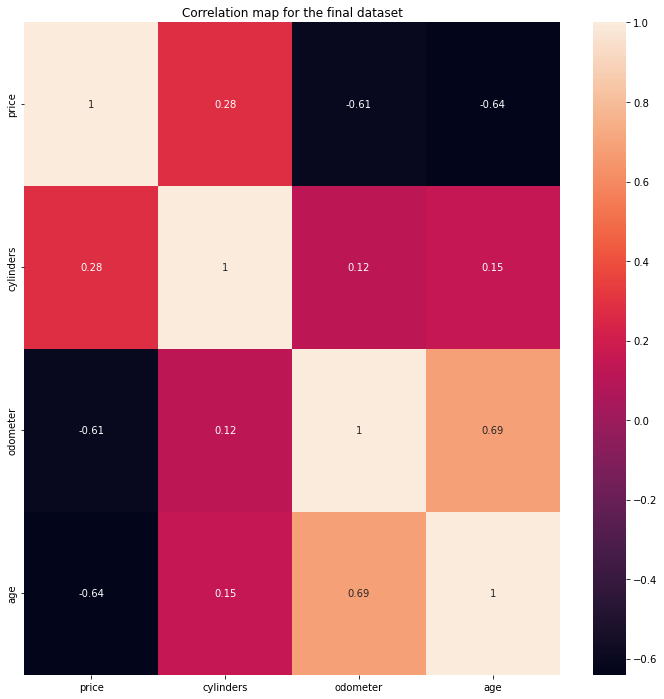

In [97]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df1.corr(), annot=True) 
plt.title('Correlation map for the final dataset');

In [98]:
Xf = df1.drop('price', axis = 1)
yf = df['price']
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, random_state = 22)

In [99]:
Xf_train.head(2)

,manufacturer,cylinders,fuel,odometer,transmission,drive,type,age
2417,ford,8.0,gas,30970.0,other,rwd,other,7.0
184426,chevrolet,6.0,gas,78094.0,automatic,rwd,SUV,5.0


In [100]:
col_hot_final = ['manufacturer','drive','type','fuel','transmission']
col_std_final = ['cylinders','odometer','age']

In [101]:
transf_final = make_column_transformer(
                (OneHotEncoder(drop="if_binary"), col_hot_final),
                (StandardScaler(), col_std_final), remainder ='passthrough')

In [102]:
pipe_final = Pipeline([('transformer', transf_final),
            ('model', TransformedTargetRegressor(regressor = RandomForestRegressor(n_estimators = 5, 
                                        random_state = 22), func=np.log, inverse_func=np.exp))])
pipe_final.fit(Xf_train, yf_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['manufacturer', 'drive',
                                                   'type', 'fuel',
                                                   'transmission']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['cylinders', 'odometer',
                                                   'age'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=5,
                                                                            random_state=22)))])

In [103]:
pred_final_train = pipe_final.predict(Xf_train)
pred_final_test = pipe_final.predict(Xf_test)
score_final = pipe_final.score(Xf_test, yf_test)
print(f'Pipe_final Train MAE: {median_absolute_error(yf_train, pred_final_train)}')
print(f'Pipe_final Test MAE: {median_absolute_error(yf_test, pred_final_test)}')
print(f'Pipe_final Accuracy Score: {score_final}')

Pipe_final Train MAE: 10.04024169287186
Pipe_final Test MAE: 493.8600848913338
Pipe_final Accuracy Score: 0.8811882083364437


Even if the model has a slightly smaller score, I like the much reduced MAE for both train and test sets, comparing to the model pipe 5. 

In [104]:
>>> scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
>>> r_multi = permutation_importance(pipe_final, Xf_test, yf_test,
...                            n_repeats=30,
...                            random_state=0, scoring = scoring)
...
>>> for metric in r_multi:
...     print(f"{metric}")
...     r = r_multi[metric]
...     for i in r.importances_mean.argsort()[::-1]:
...         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...             print(f"    {Xf_test.columns[i]:<8}"
...                   f"          {r.importances_mean[i]:.3f}"
...                   f"              +/- {r.importances_std[i]:.3f}")

r2
    age               0.619              +/- 0.004
    odometer          0.483              +/- 0.004
    cylinders          0.353              +/- 0.004
    type              0.218              +/- 0.002
    manufacturer          0.185              +/- 0.002
    drive             0.182              +/- 0.003
    fuel              0.111              +/- 0.002
    transmission          0.095              +/- 0.002
neg_mean_absolute_percentage_error
    age               0.500              +/- 0.007
    odometer          0.398              +/- 0.008
    cylinders          0.248              +/- 0.010
    manufacturer          0.209              +/- 0.005
    type              0.185              +/- 0.006
    drive             0.170              +/- 0.006
    transmission          0.072              +/- 0.005
    fuel              0.070              +/- 0.002
neg_mean_squared_error
    age               95238280.980              +/- 596414.443
    odometer          74348138.292        

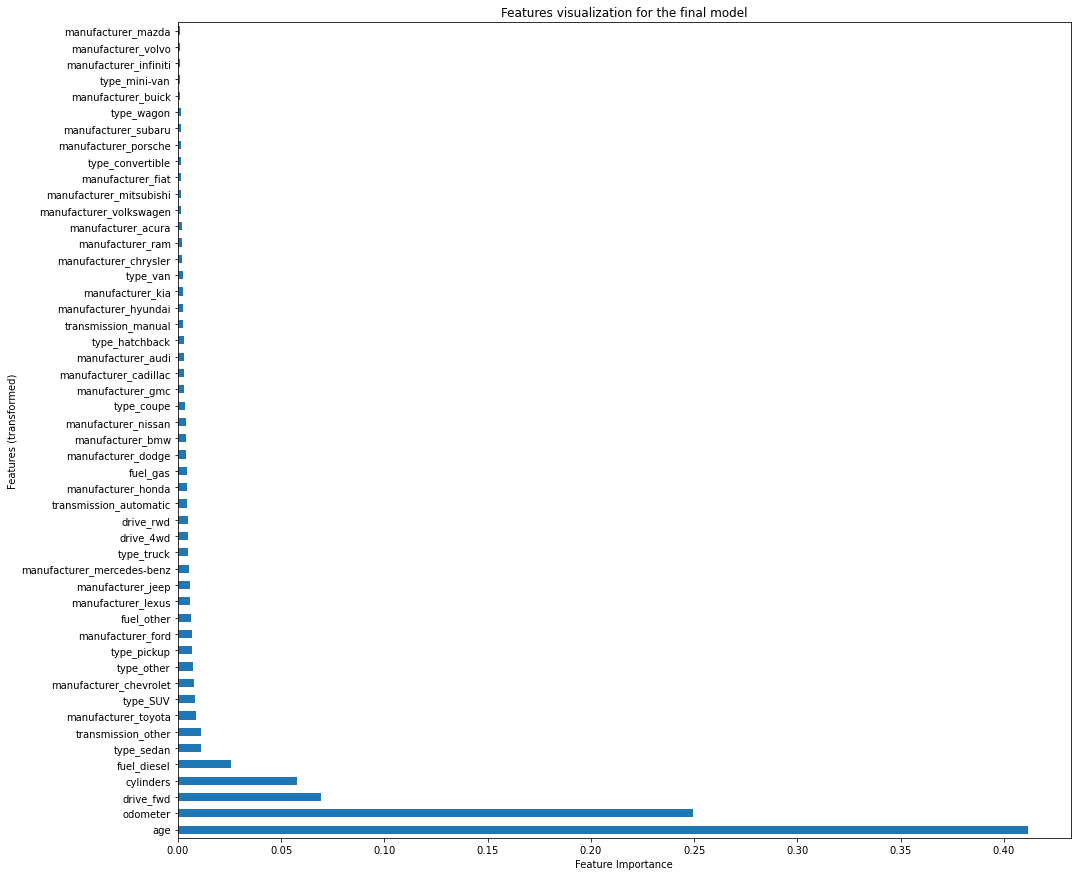

In [105]:
plt.figure(figsize = (16,15))
plt.title("Features visualization for the final model")
plt.ylabel("Features (transformed)")
plt.xlabel("Feature Importance")
feature_names = pipe_final[:-1].get_feature_names_out() 
features_clean = [i.split('__')[-1] for i in feature_names]
feat = pd.Series(
    pipe_final[-1].regressor_.feature_importances_,    
    index=features_clean
)
feat.nlargest(50).plot(kind='barh');

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

The declared purpose of this analysis was to determine the features which influence the price of used cars the most.
The second purpose was to create a prediction model to be used for predicting the price of the used car using the above features.

The most important features that influence the price of a used car are 
- age
- mileage
- car type,
- manufacturer
- type of drive
- cylinders
- fuel

The model we created has a score of 0.88 with minimal median absolute error, both of which make the model very solid and recommended for use. 

Newer diesel sedan cars, with lower mileage, forward drive and a serious engine / more cylinders sell for most money.

Sedans, SUV's and pickups sell for more money so the inventory must include these. 

Toyota, Chevrolet, Ford, Lexus, Jeep and Mercedes should be the top choices for your inventory, especially sedans and  SUVs. 

The county where the dealership is located matters for the price. Same car sells for more in some counties. We can provide at your request the distribution of average price per county. 

Convertibles, mini-vans, wagons are not selling for much.

### Next steps

Try to do separate analysis for each state in part, pay attention to the regions/counties and make a recommendation on which county drives higher sales and price in that state. 

The data does not include the acquisition cost for each car, so the profit made is not visible. Even if the car sells for more money due to various combinations of features, the profit can be smaller than for cars that sell for less amounts.
A future activity should be collecting the cost or profit per car sold so we can analyze what features influence the profit per car sold.

The inventory dynamics are not captured in the data, such as the time a car stays on the lot, which is an important metric for dealerships. 
Future activity should be collecting such additional data. 

The car model data as is collected now is not very practical for analysis. There are too many variations and too many details in the model. We determined that the data set had 29k unique models, and this was because of the way the model was entered.
A future activity should be to standardize the model data and move the additional details into separate data to be used as features in analysis.  